In [ ]:
!pip install colour-science

In [ ]:
!pip install webcolors==1.11.0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import colour
from colour import MSDS_CMFS, SDS_ILLUMINANTS, SpectralDistribution
from matplotlib import colormaps as cm
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection  # Импортируем правильный класс

In [ ]:
import webcolors

In [ ]:
# вводные данные
fn = "rcs.txt"
# словарь:
#   ключ - радиус частицы в нм
#   значение - кортеж (длины волн, интенсивность?)
total_result = {}
# список с длинами волн
wave_lens = []
# список с интенсивностью
i_data = []
cur_R = 50
# считываю спектр рассеяния
# здесь хитрое заполнение словаря - можно не вникать
with open(fn) as file:
    for line in file.readlines()[3:]:
        if "#" in line:
            if "Parameters" in line:
                total_result[cur_R] = (wave_lens, i_data)
                wave_lens, i_data = [], []
                cur_R += 10
        else:
            w_l, i_v = line.split()
            if 380 <= float(w_l) <= 780:
                wave_lens.append(float(w_l))
                i_data.append(float(i_v))
# сохраняю последние расчеты
total_result[cur_R] = (wave_lens, i_data)

In [ ]:
# проверяю сохраненные значения
total_result.keys()

dict_keys([50, 60, 70, 80, 90, 100, 110, 120])

In [ ]:
data = []
for key, val in total_result.items():
    if key > 100:
        break
    lens, rcs = val
    cur_index = rcs.index(max(rcs))
    data.append(lens[cur_index])
data

[467.69494227769,
 521.37818782609,
 578.74991891892,
 637.85629361702,
 700.4496682243,
 764.77667857143]

In [ ]:
n = 4.092
rs = np.array(range(50, 101, 10))

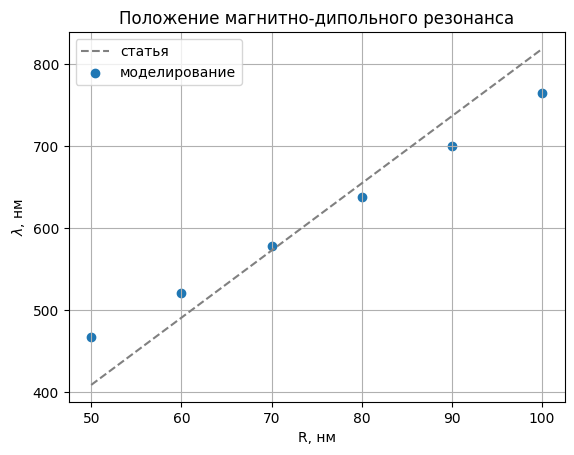

In [ ]:
plt.plot(rs, 2 * rs * n, linestyle="--", color="gray", label="статья")
plt.scatter(rs, data, label="моделирование")
plt.title("Положение магнитно-дипольного резонанса")
plt.ylabel(r"$\lambda$, нм")
plt.xlabel("R, нм")
plt.legend()
plt.grid("light")

In [ ]:
print("Длины волн:", len(total_result[120][0]))
print("Значения RCS:", len(total_result[120][1]))

Длины волн: 132
Значения RCS: 132


Тут парный кодинг с DeepSeek

In [ ]:
def show_rcs(req_R, total_result):
    # достаю из словаря данные для частицы радиусом R нанометров
    wavelengths, rcs_values = map(np.array, total_result[req_R])
    # здесь необычный способ нормализации от нейросетки
    rcs_normalized = (rcs_values - np.min(rcs_values)) / (np.max(rcs_values) - np.min(rcs_values))
    # Получение цветов из цветового пространства CIE
    cmfs = colour.MSDS_CMFS["CIE 1931 2 Degree Standard Observer"]

    # Создание спектрального распределения для RCS (сворачиваем данные в удобную структуру)
    sd = colour.SpectralDistribution(
        dict(zip(wavelengths, rcs_normalized)),
        name=f"RCS (R={str(req_R)})"
    )

    # Визуализация RCS в зависимости от длины волны
    plt.figure(figsize=(12, 6))
    colour.plotting.plot_single_sd(
        sd,
        cmfs=cmfs,
        y_label="Normalized RCS",
        title=f"Radar Cross-Section (R={str(req_R)} nm)"
    )

<Figure size 1200x600 with 0 Axes>

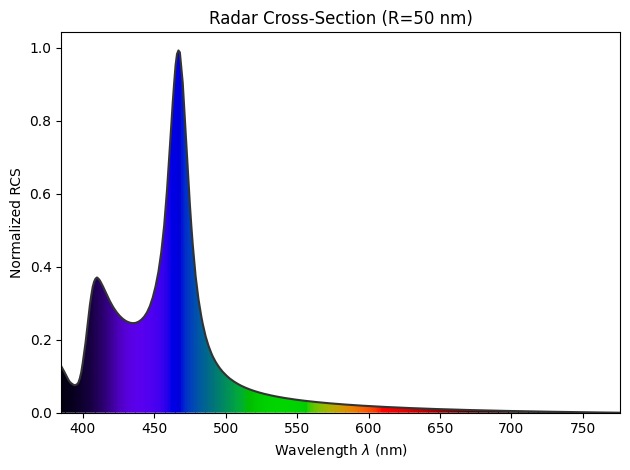

<Figure size 1200x600 with 0 Axes>

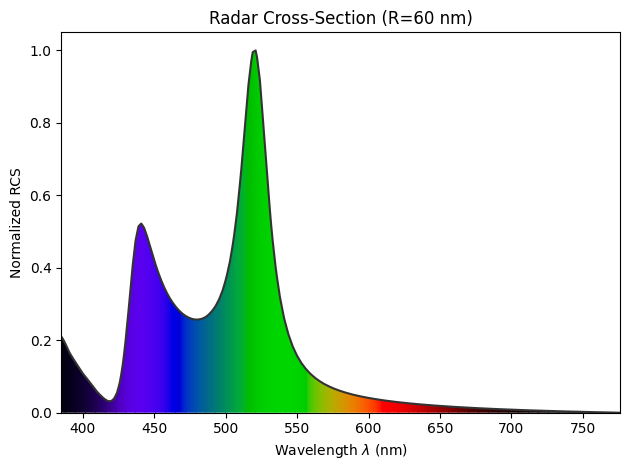

In [ ]:
for val in range(50, 70, 10):
    show_rcs(val, total_result)

In [ ]:
def get_data(req_R):
    wavelengths, rcs_values = map(np.array, total_result[req_R])
    wavelengths_resampled = np.arange(380, 790, 5)  # 380-780nm in 5nm steps
    # здесь указание, как заполнить значения
    interpolator = interp1d(wavelengths, rcs_values, kind='linear', fill_value='extrapolate')
    rcs_resampled = interpolator(wavelengths_resampled)
    # приводим к необходимому представлению
    sd = SpectralDistribution(dict(zip(wavelengths_resampled, rcs_resampled)), name=f"RCS (R={req_R})")

    # источник света 380 - 780 нм
    illuminant = colour.SDS_ILLUMINANTS["D65"]
    # Получение цветов из цветового пространства CIE
    cmfs = colour.MSDS_CMFS["CIE 1931 2 Degree Standard Observer"]

    # Преобразование RCS в цвет (используя XYZ)
    xyz = colour.sd_to_XYZ(sd, cmfs, illuminant)
    xy = colour.XYZ_to_xy(xyz)

    return xy

In [ ]:
get_data(120)

array([ 0.24433565,  0.31286992])

In [ ]:
def show_cie(req_Rs):

    xs = []
    ys = []
    labels = []
    cur_cmap = cm['gray_r']
    colors = cur_cmap(np.linspace(0.5, 1, len(req_Rs)))

    for req_R in req_Rs:
        cur_xy = get_data(req_R)
        xs.append(cur_xy[0])
        ys.append(cur_xy[1])
        labels.append(f"R = {req_R} nm")

    colour.plotting.plot_chromaticity_diagram_CIE1931(standalone=False)

    size_step = 25
    sizes = range(size_step, size_step * len(req_Rs) + size_step, size_step)

    for i in range(len(xs)):
        plt.scatter(xs[i], ys[i], label=labels[i], s=sizes[i],
                    facecolor='none', linewidths=1.5,
                    edgecolors=colors[i])

    plt.title("CIE 1931 Chromaticity Diagram with RCS Color")
    plt.legend()
    plt.show()

/usr/local/lib/python3.11/dist-packages/colour/utilities/verbose.py:322: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.11/dist-packages/colour/utilities/verbose.py:322: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028


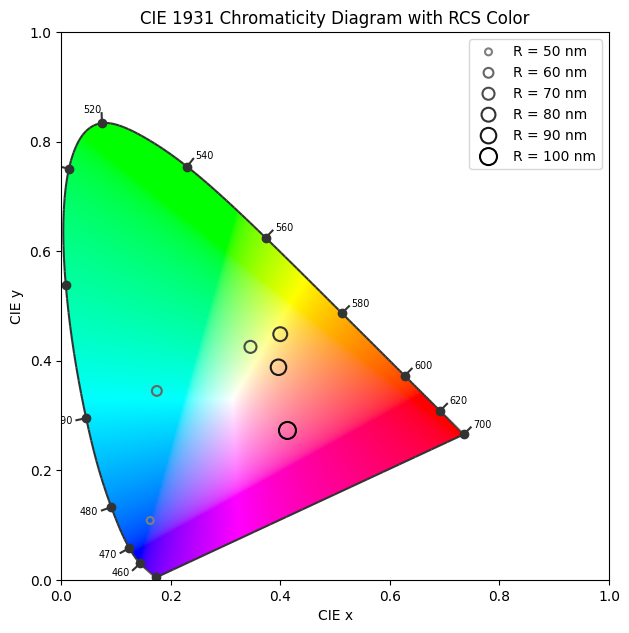

In [ ]:
show_cie(range(50, 110, 10))

In [ ]:
def convert_cie_to_rgb(xy_arr, bit_form=False, Y=0.5):
    x, y = xy_arr

    # Нормализация яркости с сохранением цветового тона
    xyY = np.array([x, y, Y])

    try:
        # Преобразование с проверкой цветового охвата
        XYZ = colour.xyY_to_XYZ(xyY)

        # Автоматическая коррекция яркости перед преобразованием
        XYZ_normalized = XYZ / max(XYZ) * Y * 1.2

        # Альтернативное преобразование с использованием разных методов
        RGB = colour.XYZ_to_sRGB(
            XYZ_normalized,
            illuminant=colour.CCS_ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['D65'],
            chromatic_adaptation_transform='CAT02'
        )

        # Улучшенная обработка выхода за пределы охвата
        RGB_clipped = colour.utilities.orient(RGB, 'Ignore')

        # Альтернативная гамма-коррекция для лучшего восприятия
        RGB_gamma_corrected = colour.models.cctf_encoding(
            RGB_clipped,
            function='sRGB'
        )

        # Дополнительная коррекция для сохранения различий
        if np.max(RGB_gamma_corrected) - np.min(RGB_gamma_corrected) < 0.15:
            RGB_gamma_corrected = colour.utilities.lerp(
                RGB_gamma_corrected,
                np.mean(RGB_gamma_corrected),
                0.3
            )

        if bit_form:
            return (RGB_gamma_corrected * 255).astype(np.uint8)

        return np.clip(RGB_gamma_corrected, 0.0, 1.0)

    except ValueError as e:
        print(f"Ошибка преобразования: {e}")
        return np.zeros(3) if not bit_form else np.zeros(3, dtype=np.uint8)

In [ ]:
def get_rgb_list(cur_Rs, bit_form=False):
    answer = []
    for cur_R in cur_Rs:
        data = get_data(cur_R)
        rgb_val = convert_cie_to_rgb(data, bit_form)
        answer.append(rgb_val)
    return answer

In [ ]:
def rgb_to_color_name(rgb_tuple):
    try:
        return webcolors.rgb_to_name(rgb_tuple)
    except ValueError:
        return _find_closest_color(rgb_tuple)

In [ ]:
def _find_closest_color(rgb):
    # Получаем все стандартные цвета CSS3
    css3_colors = webcolors.CSS3_HEX_TO_NAMES
    # Создаем словарь всех цветов (стандартные + кастомные)
    all_colors = {}

    # Добавляем стандартные цвета
    for hex_code, name in css3_colors.items():
        all_colors[name] = webcolors.hex_to_rgb(hex_code)

    # Поиск ближайшего цвета
    min_distance = float('inf')
    closest_name = "Неизвестный цвет"

    r, g, b = rgb
    target = np.array([r, g, b])

    for name, color in all_colors.items():
        color_array = np.array(color)
        distance = np.linalg.norm(target - color_array)

        if distance < min_distance:
            min_distance = distance
            closest_name = name

    return closest_name

In [ ]:
# Задайте ваши RGB-цвета (значения от 0 до 255)
colors = [
    get_rgb_list(range(50, 71, 10), bit_form=True),
    get_rgb_list(range(80, 101, 10), bit_form=True)
]
color_array = [
    get_rgb_list(range(50, 71, 10)),
    get_rgb_list(range(80, 101, 10))
]

names = [
    [rgb_to_color_name(el) for el in get_rgb_list(range(50, 71, 10), bit_form=True)],
    [rgb_to_color_name(el) for el in get_rgb_list(range(80, 101, 10), bit_form=True)]
]

sizes = [
    list(range(50, 71, 10)),
    list(range(80, 101, 10))
]

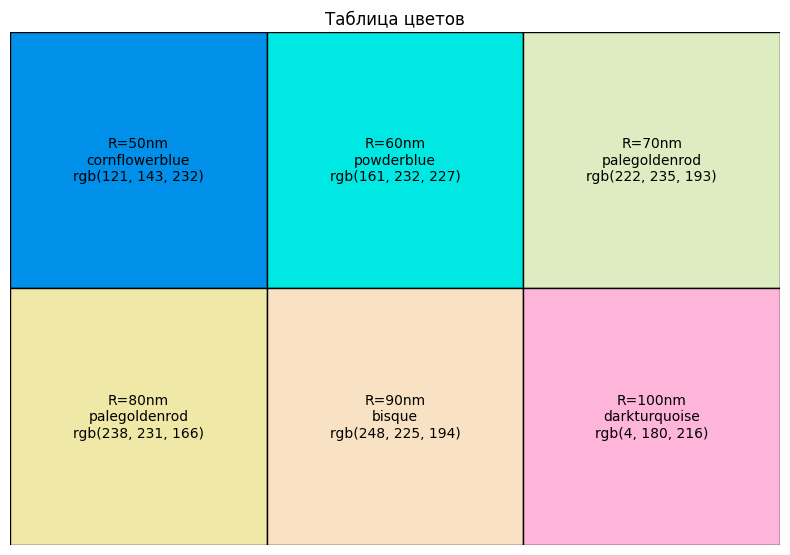

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect('equal')

# Отключаем оси
ax.axis('off')

# Создаем таблицу с цветными ячейками
for i in range(len(colors)):
    for j in range(len(colors[0])):
        # Рисуем цветной прямоугольник
        rect = plt.Rectangle((j, -i), 1, 1,
                            facecolor=color_array[i][j],
                            edgecolor='black')
        ax.add_patch(rect)

        # Добавляем текст с RGB-значениями
        rgb = colors[i][j]
        ax.text(j + 0.5, -i + 0.5,
               f'R={sizes[i][j]}nm\n{names[i][j]}\nrgb({", ".join(str(el) for el in rgb)})',
               ha='center', va='center',
               color="black",
               fontsize=10)

# Настройка границ
ax.set_xlim(0, len(colors[0]))
ax.set_ylim(-len(colors) + 1, 1)

plt.title('Таблица цветов')
plt.tight_layout()
plt.show()

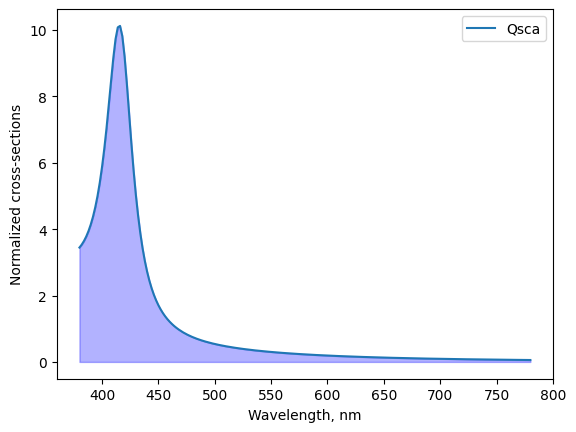

In [ ]:
data = np.genfromtxt('scattnlay-spectra.txt', skip_header=21, names=True, delimiter=', ')
x = data[data.dtype.names[0]] # x-axis has units
# # Possible labels for spectrum data: Qsca, Qabs, Qext,
# # Qsca_E_dipole, etc. (see last comment before spectra data)
a = data['Qsca']
# b = data['Qsca_E_dipole']
# c = data['Qsca_H_dipole']
#
plt.figure()
plt.plot(x, a, label='Qsca')
plt.legend()
plt.fill_between(x, a, color='blue', alpha=0.3, label='Qsca (полное рассеяние)')
plt.xlabel(data.dtype.names[0].replace('_', ', '))
plt.ylabel('Normalized cross-sections')
plt.show()


<Figure size 1200x600 with 0 Axes>

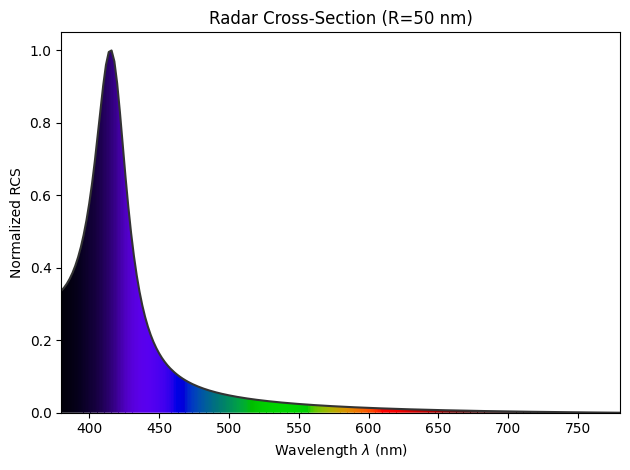

In [ ]:
show_rcs(50, {50: (x, a)})

In [ ]:
waves, i_s = [], []

with open("B.txt") as file:
    for line in file.readlines():
        wave, inten = map(float, line.split())
        if wave > 780:
            continue
        waves.append(wave)
        i_s.append(inten)

In [ ]:
wi_s = []

with open("w.txt") as file:
    for line in file.readlines()[2:]:
        wave, inten = map(float, line.split())
        if wave > 780:
            continue
        wi_s.append(inten)

In [ ]:
i_s = np.array(i_s) - np.array(wi_s)
waves = np.array(waves)
i_s

array([ 0.453754,  0.453764,  0.453717,  0.453656,  0.453722,  0.453643,
        0.453648,  0.45355 ,  0.453827,  0.453853,  0.453776,  0.453422,
        0.453116,  0.453166,  0.453088,  0.453376,  0.453023,  0.4533  ,
        0.453413,  0.453576,  0.453063,  0.452639,  0.452554,  0.452414,
        0.452353,  0.451795,  0.451679,  0.451359,  0.451444,  0.451412,
        0.451197,  0.451044,  0.450949,  0.450928,  0.4506  ,  0.450228,
        0.449929,  0.450042,  0.449922,  0.449654,  0.44927 ,  0.449177,
        0.449356,  0.449291,  0.449162,  0.449165,  0.448988,  0.448696,
        0.448284,  0.447935,  0.447795,  0.447529,  0.447387,  0.447185,
        0.446952,  0.446881,  0.446797,  0.446589,  0.446455,  0.446191,
        0.446332,  0.4461  ,  0.445944,  0.445739,  0.445674,  0.44545 ,
        0.44528 ,  0.445222,  0.445149,  0.444873,  0.444599,  0.444532,
        0.444338,  0.443912,  0.443623,  0.443422,  0.443473,  0.44316 ,
        0.443062,  0.442918,  0.442735,  0.442402, 

In [ ]:
total_result[0] = (waves, i_s)

<Figure size 1200x600 with 0 Axes>

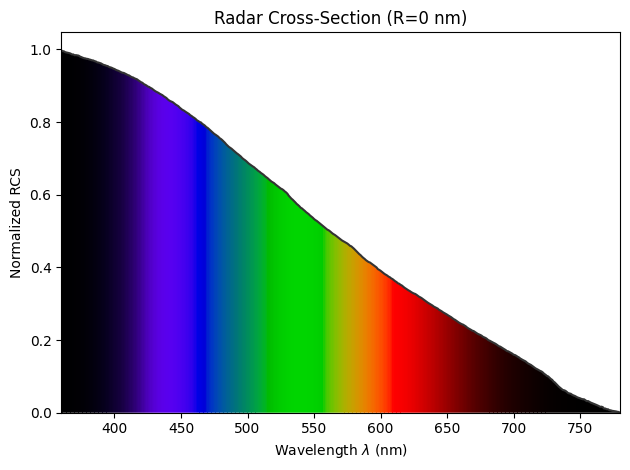

In [ ]:
show_rcs(0, total_result)

/usr/local/lib/python3.11/dist-packages/colour/utilities/verbose.py:322: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.11/dist-packages/colour/utilities/verbose.py:322: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028


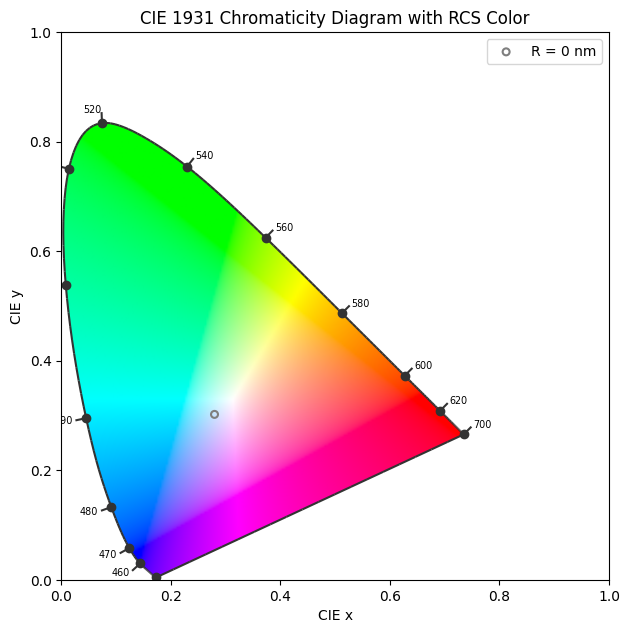

In [ ]:
show_cie([0])

In [ ]:
def get_fixed_data(fn):
    data = np.genfromtxt(fn, skip_header=21, names=True, delimiter=', ')
    x = data[data.dtype.names[0]]
    a = data['Qsca']
    return a

In [ ]:
data = np.genfromtxt("20.txt", skip_header=21, names=True, delimiter=', ')
x = data[data.dtype.names[0]]
total = data['Qsca']

In [ ]:
total

array([ 0.02468919,  0.02414679,  0.02361939,  0.02310649,  0.02260761,
        0.02212229,  0.02165007,  0.02119054,  0.02074327,  0.02030788,
        0.01988398,  0.01947121,  0.01906922,  0.01867765,  0.0182962 ,
        0.01792453,  0.01756236,  0.01720938,  0.01686531,  0.01652989,
        0.01620285,  0.01588394,  0.01557291,  0.01526953,  0.01497357,
        0.01468482,  0.01440305,  0.01412808,  0.0138597 ,  0.01359771,
        0.01334194,  0.01309221,  0.01284835,  0.01261019,  0.01237757,
        0.01215033,  0.01192833,  0.01171141,  0.01149944,  0.01129229,
        0.01108982,  0.0108919 ,  0.01069841,  0.01050923,  0.01032425,
        0.01014335,  0.00996643,  0.00979337,  0.00962408,  0.00945846,
        0.00929642,  0.00913785,  0.00898268,  0.0088308 ,  0.00868215,
        0.00853663,  0.00839417,  0.00825469,  0.00811811,  0.00798437,
        0.00785338,  0.00772509,  0.00759943,  0.00747632,  0.00735572,
        0.00723755,  0.00712176,  0.00700829,  0.00689709,  0.00

In [ ]:
for cur_fn in [str(el) for el in range(25, 66, 5)]:
    total += get_fixed_data(f"{cur_fn}.txt")

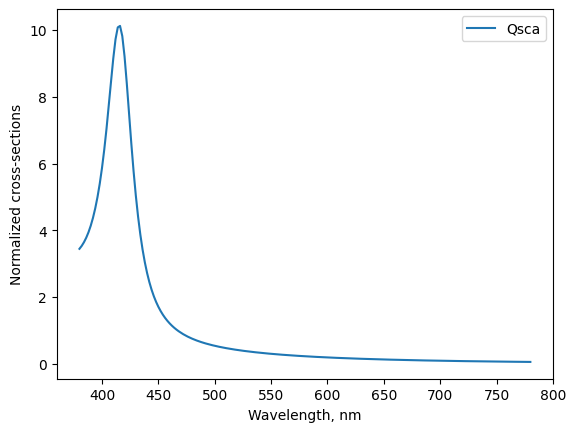

In [ ]:
plt.figure()
plt.plot(x, a, label='Qsca')
plt.legend()
plt.xlabel(data.dtype.names[0].replace('_', ', '))
plt.ylabel('Normalized cross-sections')
plt.show()

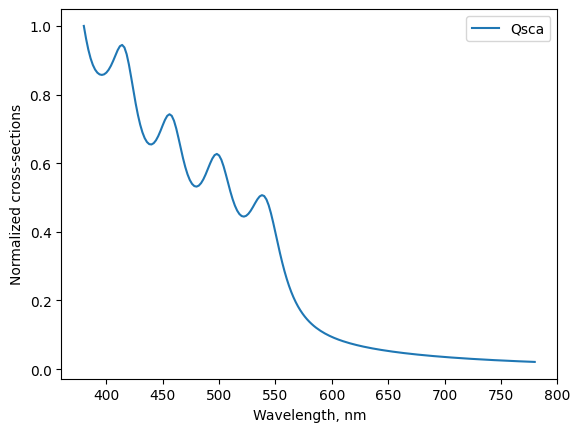

In [ ]:
plt.figure()
plt.plot(x, total / max(total), label='Qsca')
plt.legend()
plt.xlabel(data.dtype.names[0].replace('_', ', '))
plt.ylabel('Normalized cross-sections')
plt.show()

In [ ]:
total

array([ 26.2266861 ,  25.24294246,  24.41350173,  23.75009772,
        23.2481278 ,  22.88994716,  22.65415301,  22.52230065,
        22.48204655,  22.52756888,  22.65807794,  22.8747483 ,
        23.17592601,  23.55024616,  23.96780526,  24.37153837,
        24.67476558,  24.77402745,  24.581798  ,  24.06679184,
        23.27383944,  22.30569774,  21.2809877 ,  20.29810693,
        19.42083655,  18.6815887 ,  18.09158515,  17.65060733,
        17.35370464,  17.19484523,  17.16821353,  17.26772158,
        17.48496135,  17.80560106,  18.20435964,  18.63948542,
        19.04932973,  19.35555492,  19.47740555,  19.35605346,
        18.97826153,  18.38390507,  17.6511654 ,  16.86936265,
        16.11561362,  15.44402893,  14.88601503,  14.45598487,
        14.15779691,  13.98969143,  13.94720248,  14.02422701,
        14.21254173,  14.49997962,  14.86748288,  15.28554366,
        15.71126551,  16.08830315,  16.35249539,  16.44461018,
        16.32737197,  15.99900978,  15.4951435 ,  14.87

<Figure size 1200x600 with 0 Axes>

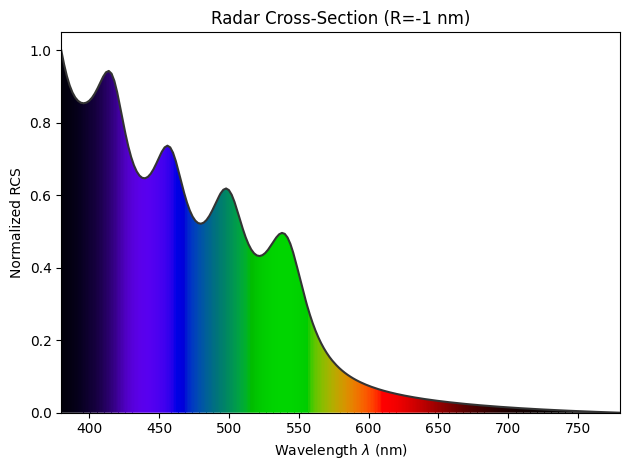

In [ ]:
total_result[-1] = (x, total)
show_rcs(-1, total_result)

/usr/local/lib/python3.11/dist-packages/colour/utilities/verbose.py:322: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.11/dist-packages/colour/utilities/verbose.py:322: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028


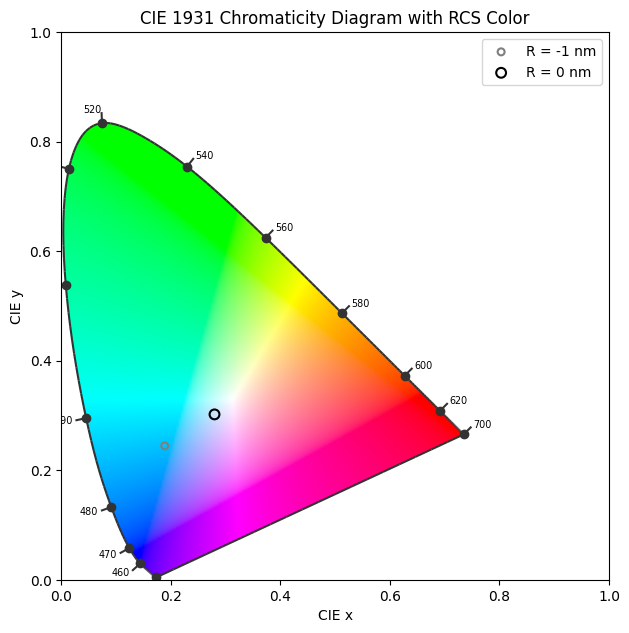

In [ ]:
show_cie([-1, 0])

In [ ]:
# костыль
def show_piv_rcs(req_R, total_result):
    # достаю из словаря данные для частицы радиусом R нанометров
    wavelengths, rcs_values = map(np.array, total_result[req_R])
    # здесь необычный способ нормализации от нейросетки
    rcs_normalized = (rcs_values - np.min(rcs_values)) / (np.max(rcs_values) - np.min(rcs_values))
    # Получение цветов из цветового пространства CIE
    cmfs = colour.MSDS_CMFS["CIE 1931 2 Degree Standard Observer"]

    # Создание спектрального распределения для RCS (сворачиваем данные в удобную структуру)
    sd = colour.SpectralDistribution(
        dict(zip(wavelengths, rcs_normalized)),
        name=f"RCS"
    )

    # Визуализация RCS в зависимости от длины волны
    plt.figure(figsize=(12, 6))
    colour.plotting.plot_single_sd(
        sd,
        cmfs=cmfs,
        y_label="Normalized intensity",
        title=f"RCS practical"
    )

<Figure size 1200x600 with 0 Axes>

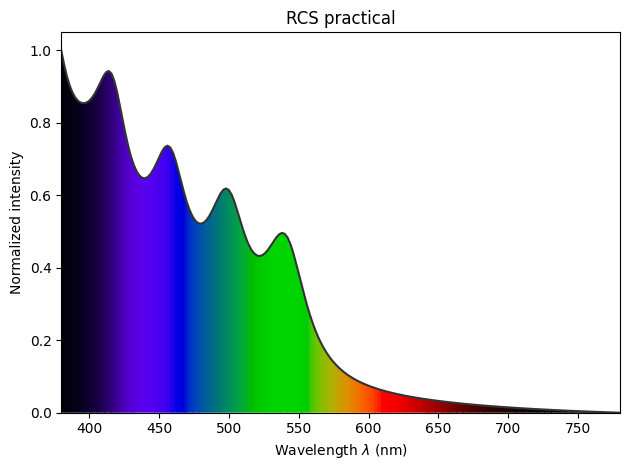

In [ ]:
show_piv_rcs(-1, total_result)

<Figure size 1200x600 with 0 Axes>

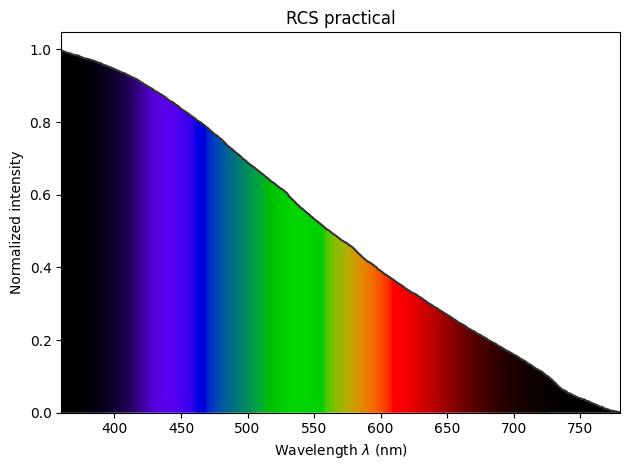

In [ ]:
show_piv_rcs(0, total_result)

In [ ]:
def show_piv_cie(req_Rs):

    xs = []
    ys = []
    labels = []
    cur_cmap = cm['gray_r']
    colors = cur_cmap(np.linspace(0.5, 1, len(req_Rs)))

    for req_R in req_Rs:
        cur_xy = get_data(req_R)
        xs.append(cur_xy[0])
        ys.append(cur_xy[1])
        labels.append(f"R = {req_R} nm")

    labels = ["теория", "практика"]

    colour.plotting.plot_chromaticity_diagram_CIE1931(standalone=False)

    size_step = 25
    sizes = range(size_step, size_step * len(req_Rs) + size_step, size_step)

    for i in range(len(xs)):
        plt.scatter(xs[i], ys[i], label=labels[i], s=sizes[i],
                    facecolor='none', linewidths=1.5,
                    edgecolors=colors[i])

    plt.title("CIE 1931 Chromaticity Diagram with RCS Color")
    plt.legend()
    plt.show()

/usr/local/lib/python3.11/dist-packages/colour/utilities/verbose.py:322: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.11/dist-packages/colour/utilities/verbose.py:322: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028


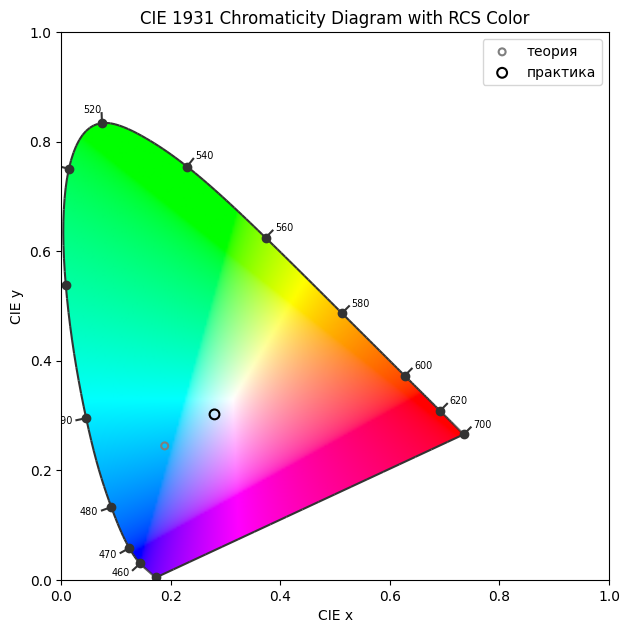

In [ ]:
show_piv_cie([-1, 0])

In [ ]:
data = np.genfromtxt('50.txt', skip_header=21, names=True, delimiter=', ')
x_25 = data[data.dtype.names[0]] # x-axis has units
# # Possible labels for spectrum data: Qsca, Qabs, Qext,
# # Qsca_E_dipole, etc. (see last comment before spectra data)
a_25 = data['Qsca']

In [ ]:
data = np.genfromtxt('55.txt', skip_header=21, names=True, delimiter=', ')
x_30 = data[data.dtype.names[0]] # x-axis has units
# # Possible labels for spectrum data: Qsca, Qabs, Qext,
# # Qsca_E_dipole, etc. (see last comment before spectra data)
a_30 = data['Qsca']

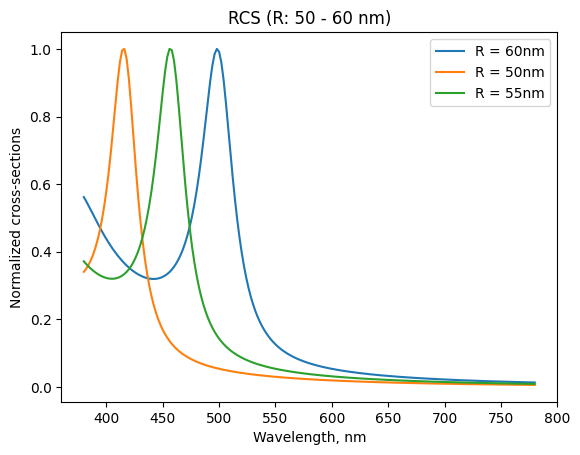

In [ ]:
data = np.genfromtxt('60.txt', skip_header=21, names=True, delimiter=', ')
x = data[data.dtype.names[0]] # x-axis has units
# # Possible labels for spectrum data: Qsca, Qabs, Qext,
# # Qsca_E_dipole, etc. (see last comment before spectra data)
a = data['Qsca']
plt.figure()
plt.title("RCS (R: 50 - 60 nm)")
plt.plot(x, a / max(a), label='R = 60nm')
plt.plot(x_25, a_25 / max(a_25) , label='R = 50nm')
plt.plot(x_30, a_30 / max(a_30), label='R = 55nm')
plt.legend()
plt.xlabel(data.dtype.names[0].replace('_', ', '))
plt.ylabel('Normalized cross-sections')
plt.show()
